In [1]:
import Pkg;
Pkg.activate(@__DIR__);
Pkg.instantiate();

  Activating environment at `~/SSD/Code/Julia/tinympc-julia/quat_mpc_cone/Project.toml`


In [2]:
using LinearAlgebra
using BlockDiagonals
using ForwardDiff
using Plots
using Random;
using Printf

In [3]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2]
        v[3] 0 -v[1]
        -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s -v'
        v s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1, 3); I]
function qtoQ(q)
    return H' * T * L(q) * T * L(q) * H
end
function G(q)
    G = L(q) * H
end
function rptoq(ϕ)
    (1 / sqrt(1 + ϕ' * ϕ)) * [1; ϕ]
end
function qtorp(q)
    q[2:4] / q[1]
end
function E(q)
    E = BlockDiagonal([1.0 * I(3), G(q), 1.0 * I(6)])
end

E (generic function with 1 method)

In [4]:
#Quadrotor parameters
m = 0.035
ℓ = 0.046
J = [16.6e-6 0.83e-6 0.72e-6
    0.83e-6 16.6e-6 1.8e-6
    0.72e-6 1.8e-6 29.3e-6];
g = 9.81
# thrustToTorque = 0.005964552
thrustToTorque = 0.0008
ℓ = 0.046 / sqrt(2)
scale = 65535
kt = 2.245365e-6 * scale # u is PWM in range [0...1]
km = kt * thrustToTorque #4.4733e-8

freq1 = 50
h = 1 / freq1 #50 Hz

Nx = 13     # number of states (quaternion)
Nx̃ = 12     # number of states (linearized)
Nu = 4     # number of controls
nx = Nx̃
nu = Nu
Tfinal = 5.0 # final time
Nt = Int(Tfinal / h) + 1    # number of time steps
t_vec = h * (0:Nt-1)
thist = Array(range(0, h * (Nt - 1), step=h));

In [5]:
function quad_dynamics(x, u)
  r = x[1:3]
  q = x[4:7] / norm(x[4:7]) #normalize q just to be careful
  v = x[8:10]
  ω = x[11:13]
  Q = qtoQ(q)

  ṙ = v
  q̇ = 0.5 * L(q) * H * ω

  v̇ = [0; 0; -g] + (1 / m) * Q * [zeros(2, 4); kt * ones(1, 4)] * u

  ω̇ = J \ (-hat(ω) * J * ω + [-ℓ*kt -ℓ*kt ℓ*kt ℓ*kt; -ℓ*kt ℓ*kt ℓ*kt -ℓ*kt; -km km -km km] * u)

  return [ṙ; q̇; v̇; ω̇]
end
function quad_dynamics_rk4(x, u, h)
  #RK4 integration with zero-order hold on u
  f1 = quad_dynamics(x, u)
  f2 = quad_dynamics(x + 0.5 * h * f1, u)
  f3 = quad_dynamics(x + 0.5 * h * f2, u)
  f4 = quad_dynamics(x + h * f3, u)
  xn = x + (h / 6.0) * (f1 + 2 * f2 + 2 * f3 + f4)
  xn[4:7] .= xn[4:7] / norm(xn[4:7]) #re-normalize quaternion
  return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [6]:
#Goal state
@show uhover = (m * g / kt / 4) * ones(4)  # m = 30g and max thrust = 60g
rg = [0.0; 0; 0.0]
qg = [1.0; 0; 0; 0]
vg = zeros(3)
ωg = zeros(3)
xg = [rg; qg; vg; ωg];

uhover = (((m * g) / kt) / 4) * ones(4) = [0.5833333520642209, 0.5833333520642209, 0.5833333520642209, 0.5833333520642209]


In [7]:
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x -> quad_dynamics_rk4(x, uhover, h), xg)
B = ForwardDiff.jacobian(u -> quad_dynamics_rk4(xg, u, h), uhover);
Ã = Array(E(qg)' * A * E(qg))
B̃ = Array(E(qg)' * B);
function discrete_dynamics(params, x, u, k)
  Ã * x + B̃ * u
end

discrete_dynamics (generic function with 1 method)

In [8]:
#Linearize dynamics about hover
A1 = ForwardDiff.jacobian(x -> quad_dynamics(x, uhover), xg)
B1 = ForwardDiff.jacobian(u -> quad_dynamics(xg, u), uhover);
Ã1 = Array(E(qg)' * A1 * E(qg))
B̃1 = Array(E(qg)' * B1);

In [9]:
# @printf("%s", export_mat_to_eigen("A << ", Ã))

In [10]:
# Adaptive step in MPC horizon: use normal dt and model in the first specified 
# `adaptive_step` steps and after that use the stretch mode (larger dt and model)
freq2 = 1
h = 1 / freq2 #25 Hz stretch interval dynamics
#Linearize dynamics about hover
As = ForwardDiff.jacobian(x -> quad_dynamics_rk4(x, uhover, h), xg)
Bs = ForwardDiff.jacobian(u -> quad_dynamics_rk4(xg, u, h), uhover);
Ãs = Array(E(qg)' * As * E(qg))
B̃s = Array(E(qg)' * Bs);
function discrete_dynamics_stretch(params, x, u, k)
  Ãs * x + B̃s * u
end


discrete_dynamics_stretch (generic function with 1 method)

In [11]:
h = 1 / freq1 #50 Hz normal dynamics
step_ratio = Int(freq1 / freq2)
# display(Ãs)
# display(Ã)

50

In [12]:
# IHLQR terminal cost
P = [zeros(nx, nx) for i = 1:200]   # cost to go quadratic term
p = [zeros(nx) for i = 1:200]      # cost to go linear term
d = [zeros(nu) for i = 1:200-1]    # feedforward control
K = [zeros(nu, nx) for i = 1:200-1] # feedback gain

# Cost weights
# Saved
# max_dev_x = [0.1; 0.1; 0.1;  0.5; 0.5; 0.05;  0.5; 0.5; 0.5;  0.5; 0.5; 0.1]
# max_dev_u = [0.5; 0.5; 0.5; 0.5]/10
max_dev_x = [0.1; 0.1; 0.1; 0.5; 0.5; 0.05; 0.5; 0.5; 0.5; 0.7; 0.7; 0.2] / 1
max_dev_u = [0.5; 0.5; 0.5; 0.5] / 10
Q = diagm(1 ./ (max_dev_x .^ 2))
R = diagm(1 ./ (max_dev_u .^ 2))

# Q = Array(Diagonal([10; 10; 10; 1; 1; 1; 1; 1; 1; 1; 1; 1.]));
# R = Array(1*I(Nu));
Qf = 1 * Q

# IHLQR terminal cost for orginal problem
P[200] .= Q
for k = (200-1):-1:1
    K[k] .= (R + B̃s' * P[k+1] * B̃s) \ (B̃s' * P[k+1] * Ãs)
    P[k] .= Q + Ãs' * P[k+1] * (Ãs - B̃s * K[k])
end
Qf = P[1]

# PENALTY - important!! Trade-off between obj and constraint
ρ = 100.0 * 1

# data for new admm formulation
R̃ = R + ρ * I
Q̃ = Q + ρ * I
Q̃f = Qf + ρ * I

# Precompute
cache = (
    Kinf=zeros(nu, nx),
    Pinf=zeros(nx, nx),
    Kinf2=zeros(nu, nx),
    Pinf2=zeros(nx, nx),
    Quu_inv=zeros(nu, nu),
    Quu_inv2=zeros(nu, nu),
    AmBKt=zeros(nx, nx),
    AmBKt2=zeros(nx, nx), #(Ã - B̃*K[1])',
    coeff_d2p=zeros(nx, nu),
    coeff_d2p2=zeros(nx, nu),
)

# IHLQR terminal cost for new problem
P = [zeros(nx, nx) for i = 1:200]   # cost to go quadratic term
p = [zeros(nx) for i = 1:200]      # cost to go linear term
d = [zeros(nu) for i = 1:200-1]    # feedforward control
K = [zeros(nu, nx) for i = 1:200-1] # feedback gain

P[200] .= Q̃f
# For streched dynamics (unused -> set `adaptive_step = 0`)
for k = (200-1):-1:1
    K[k] .= (R̃ + B̃s' * P[k+1] * B̃s) \ (B̃s' * P[k+1] * Ãs)
    P[k] .= Q̃ + Ãs' * P[k+1] * (Ãs - B̃s * K[k])
end
cache.Kinf2 .= K[1]  # correct, tested with dlqr
cache.Pinf2 .= P[1]
cache.AmBKt2 .= (Ãs - B̃s * K[1])'
cache.Quu_inv2 .= (R̃ + B̃s' * cache.Pinf2 * B̃s) \ I
cache.coeff_d2p2 .= cache.Kinf2' * R̃ - cache.AmBKt2 * cache.Pinf2 * B̃s;
# For normal dynamics
for k = (200-1):-1:1
    K[k] .= (R̃ + B̃' * P[k+1] * B̃) \ (B̃' * P[k+1] * Ã)
    P[k] .= Q̃ + Ã' * P[k+1] * (Ã - B̃ * K[k])
end
cache.Kinf .= K[1]
cache.Pinf .= P[1]
cache.AmBKt .= (Ã - B̃ * K[1])'
cache.Quu_inv .= (R̃ + B̃' * cache.Pinf * B̃) \ I
display(cond(R̃ + B̃' * cache.Pinf * B̃))
cache.coeff_d2p .= cache.Kinf' * R̃ - cache.AmBKt * cache.Pinf * B̃


32.64398662398766

12×4 Matrix{Float64}:
  0.00516      -0.00562206   -0.00505538    0.00551743
 -0.00509182   -0.00551038    0.00504936    0.00555284
 -0.000340358  -0.000340358  -0.000340358  -0.000340358
  0.0106516     0.0112257    -0.010271     -0.0116063
  0.0110025    -0.0119583    -0.0100541     0.0110099
  0.00865975   -0.0092957     0.0110668    -0.0104309
  0.00231489   -0.00251901   -0.00220866    0.00241279
 -0.00226701   -0.00242794    0.00222425    0.0024707
 -9.65829e-5   -9.65829e-5   -9.65829e-5   -9.65829e-5
  8.30879e-5    2.90652e-5   -2.11664e-5   -9.09867e-5
  0.000126166  -0.000133699   2.86312e-5   -2.10977e-5
  0.00116583   -0.00122154    0.00137686   -0.00132115

In [13]:
# display(cache.Kinf)
# # C Language for LQR2 alone
# @printf("FOR C:\n");
# str = "static float K[NU][NXt] = {\n"
# for i = 1:4
#   str = str * "  {"
#   for j = 1:12
#     # if abs(K[i, j]) < 1e-6
#     #   K[i, j] = 0.0
#     # end
#     this_str = @sprintf("%.6f", cache.Kinf[i, j])

#     str = str * this_str * "f"
#     if j < 12
#       str = str * ","
#     end
#   end
#   str = str * "},\n"
# end
# str = str * "};"
# @printf("%s",str)

In [164]:
#Feedback tracking controller
include("../LibTinyMPC.jl")
N = 10
dt = 1 / freq1
Tfinal = 8.0 # final time
Nt = Int(Tfinal / h) + 1    # number of time steps
t_vec = h * (0:Nt-1)


#Create trajectory to follow
z_ref = 1.0
Xref = [[zeros(3); 1; zeros(9)] for i = 1:Nt]
Δx̃ref = [zeros(nx) for i = 1:Nt]
ΔUref = [zeros(nu) for i = 1:Nt-1]

## Hovering
# Xref = [xg for i = 1:Nt]

# Number-eight
Xref = [[1*cos(t)*sin(t);1*cos(t);z_ref;1;zeros(9)] for t = range(-pi/2, 3*pi/2, length = Nt)]  

## Triangle
# p0 = [0; 0; z_ref];
# p1 = [3; 4; z_ref];
# p2 = [0; 8; z_ref];
# p3 = [0; -2; z_ref];
# range1 = collect(LinRange(p0, p1, round(Int, (Nt) / 3)))
# range2 = collect(LinRange(p1, p2, round(Int, (Nt) / 3)))
# range3 = collect(LinRange(p2, p3, round(Int, (Nt) / 3) + 1))
# range123 = [range1; range2; range3]
# for k = 1:Nt
#     Xref[k][1:3] .= range123[k]
# end

# Square
# p0 = [0; 0; 0.5]; p1 = [2; 0; 0.5]; p2 = [2; 2; 0.5]; p3 = [0; 2; 0.5]
# range1 = collect(LinRange(p0, p1, round(Int,(Nt)/4)))
# range2 = collect(LinRange(p1, p2, round(Int,(Nt)/4)))
# range3 = collect(LinRange(p2, p3, round(Int,(Nt)/4)))
# range4 = collect(LinRange(p3, p0, round(Int,(Nt)/4)+1))
# range1234 = [range1; range2; range3; range4]
# for k = 1:Nt
#     Xref[k][1:3] .= range1234[k]
# end

# Velocity reference: speeds up the tracking but less smooth
for i = 1:Nt-1
    Xref[i][8:10] = (Xref[i+1][1:3] - Xref[i][1:3]) / dt / 1.0
end
for k = 1:Nt
    x = Xref[k]
    q = x[4:7]
    ϕ = qtorp(L(qg)' * q)
    Δx̃ref[k] .= [x[1:3] - rg; ϕ; x[8:10] - vg; x[11:13] - ωg]
end


u_min = -uhover #-0.5*ones(nu)
u_max = 1 .- uhover #0.5*ones(nu)
# u_min = -50.0*ones(nu)
# u_max = 50.0*ones(nu)
# state is x y v θ
x_min = []
# x_min[3] = 0.85
x_max = []
# x_max[1] = 3.05
# Halfspace
Acu = []
bcu = 0.0
Acx = []
bcx = 0.0

# Obstacle
obs_c = [3.1, 4.0, 1.0]
obs_r = 0.5

# previous MPC iterate
X = [zeros(nx) for i = 1:N]
U = [zeros(nu) for k = 1:N-1]
ZU = [zeros(nu) for i = 1:N-1]
ZU_new = [zeros(nu) for i = 1:N-1]
YU = [zeros(nu) for i = 1:N-1]
ZX = [zeros(nx) for i = 1:N]
ZX_new = [zeros(nx) for i = 1:N]
YX = [zeros(nx) for i = 1:N]

params = (
    nx=nx, nu=nu,
    N=N, Q=Q, R=R, Qf=Qf,
    en_box_input=1, u_min=u_min, u_max=u_max, Acu=Acu, bcu=bcu,
    en_box_state=0, x_min=x_min, x_max=x_max, Acx=Acx, bcx=bcx,
    en_hplane_state=0,
    en_box_soc=0, en_soc_state=1, mu=0.7,
    Xref=Δx̃ref, Uref=ΔUref, dt=dt, cache=cache,
);


P = [zeros(nx, nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu, nx) for i = 1:N-1] # feedback gain
qq = [zeros(nx) for i = 1:N]
r = [zeros(nu) for i = 1:N-1]

verbose = 0
adaptive_step = 0
iters = zeros(10000)
function controller_mpc(params, x, k)
    q = x[4:7]
    ϕ = qtorp(L(qg)' * q)

    Δx̃ = [x[1:3] - rg; ϕ; x[8:10] - vg; x[11:13] - ωg]
    X[1] .= Δx̃

    # U = [zeros(nu) for k = 1:N-1]
    # ZU = [zeros(nu) for i = 1:N-1]
    # ZU_new = [zeros(nu) for i = 1:N-1]
    # YU = [zeros(nu) for i = 1:N-1]
    # ZX = [zeros(nx) for i = 1:N]
    # ZX_new = [zeros(nx) for i = 1:N]
    # YX = [zeros(nx) for i = 1:N]

    u, status, iters[k] = solve_admm!(params, qq, r, p, d, X, ZX, ZX_new, YX, U, ZU, ZU_new, YU; ρ=ρ, abs_tol=1e-2, max_iter=50, adaptive_step=adaptive_step)
    # u = -cache.Kinf*(Δx̃ - Δx̃ref[k])
    # display(iters[k])
    # status == 0 && display("Max iteration reached")
    return u + uhover
end

#ASK: Do I need to stretch the reference?
function update_reference(params, k)
    Uref_ = 1 * ΔUref[k:N+k-2]
    Xref_ = 1 * Δx̃ref[k:N+k-1]

    if (adaptive_step > 0)
        for i = 3:N-1
            Uref_[i] .= ΔUref[k+1+(i-2)*step_ratio]
            Xref_[i] .= Δx̃ref[k+1+(i-2)*step_ratio]
        end
        Xref_[N] .= Δx̃ref[k+1+(N-2)*step_ratio]
        # for i = 3:N-1
        #     Xref_[i][7:9] = (Xref_[i+1][1:3] - Xref_[i][1:3])/freq2
        # end
    end

    params_new = (; params..., Uref=Uref_, Xref=Xref_)  # update ref
    return params_new
end

function update_constraint(params, X, k)
    Acx_ = [zeros(3) for i = 1:N]  # only three for position
    bcx_ = [1.0 for i = 1:N]
    for k = 1:N
        xp = X[k][1:3]
        vecXC = obs_c - xp
        d = sqrt(vecXC' * vecXC)
        if (d > (3 * obs_r))
            # unactivated if far from obstacle
            # Acx_[k] = zeros(3)
            # bcx_[k] = 1.0
        else
            vecXI = vecXC * (d - obs_r) / d
            Xi = xp + vecXI
            ∇f = 2 * (obs_c - Xi)
            denom = sqrt(∇f' * ∇f)
            Acx_[k] = ∇f / denom
            bcx_[k] = ∇f' * Xi / denom
        end
    end
    params_new = (; params..., Acx=Acx_, bcx=bcx_)  # update ref
    # println(xp, Acx_, bcx_)
    return params_new
end


update_constraint (generic function with 1 method)

In [165]:
# Simulation
uhist = [zeros(Nu) for i in 1:Nt-1]
xhist = [zeros(Nx) for i in 1:Nt]
Random.seed!(12);
# xhist[1] .= [rg+0*randn(3)/3; L(qg)*rptoq([1; 0; 0]); vg; ωg]  # initial conditions
# xhist[1] .= Xref[1]
xhist[1] .= Xref[1];
# xhist[1][1:3] += rand(3) * 0.2;
backward_pass!(Q̃, R̃, P, params, adaptive_step)
Nsim = Nt - 100 - 1
for k = 1:Nsim
# for k = 1:10
    params = update_reference(params, k)
    params = update_constraint(params, X, k)
    # display(params1.Xref)
    # display(xhist[k])
    # shift_fill(U)
    uhist[k] = controller_mpc(params, xhist[k], k)
    uhist[k] = clamp.(uhist[k], (uhover+u_min)[1], (uhover+u_max)[1])
    xhist[k+1] = quad_dynamics_rk4(xhist[k], uhist[k], h)
end

In [180]:
display(maximum(iters))
for i = 1:length(Nsim)
  # xhist[i][3] > 1.0 + 0.01 && error("infeasibilty")
  (norm(xhist[i][1:2]) - params.mu * xhist[i][3]) > 0.001 && error("infeasibilty")
end
maximum(xhist)

50.0

13-element Vector{Float64}:
  0.49217056263297865
  0.6348551739785717
  1.2612598247398077
  0.9991821577939263
 -0.010992507189799803
 -0.03887904235044314
 -0.0016125749186499962
  0.006788575970906603
 -0.5281047360898309
 -0.1828451176986347
  0.058040671121263245
 -0.1354697875741259
  0.018288370648054098

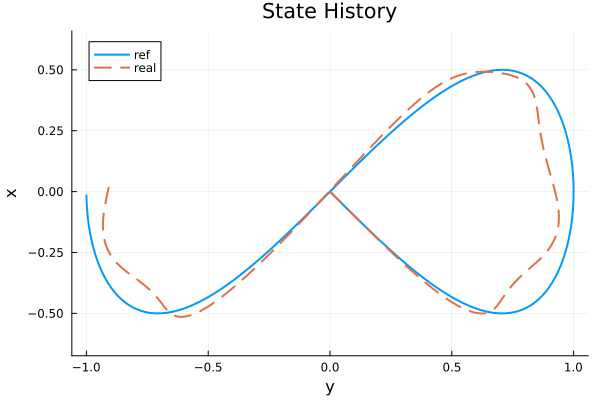

In [167]:
Xsim_m = mat_from_vec(Xref[1:Nsim])
plot(Xsim_m[2, :], Xsim_m[1, :], label="ref", linestyle=:solid, linewidth=2, title="State History", xlabel="y", ylabel="x")
Xsim_m = mat_from_vec(xhist[1:Nsim])
display(plot!(Xsim_m[2, :], Xsim_m[1, :], label="real", linestyle=:dash, linewidth=2, title="State History", xlabel="y", ylabel="x", aspect_ratio=:equal))
# display(scatter!([obs_c[2]], [obs_c[1]], color="red", label="", markersize=70 * obs_r))


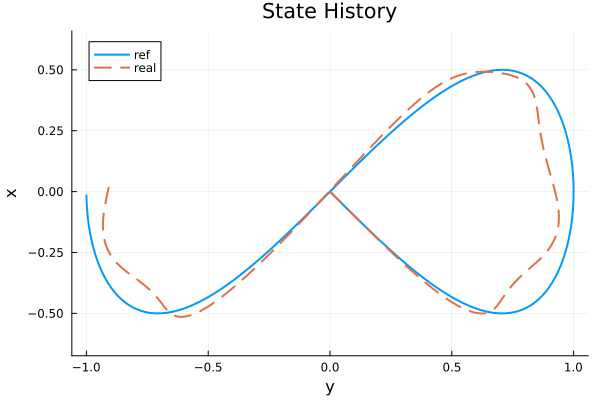

In [168]:
Xsim_m = mat_from_vec(Xref[1:1:Nsim])
plot(Xsim_m[2, :], Xsim_m[1, :], label="ref",
  linestyle=:solid, linewidth=2,
  title="State History", xlabel="y", ylabel="x")
Xsim_m = mat_from_vec(xhist[1:1:Nsim])
display(plot!(Xsim_m[2, :], Xsim_m[1, :], label="real", linestyle=:dash, linewidth=2,
  title="State History", xlabel="y", ylabel="x", aspect_ratio=:equal))

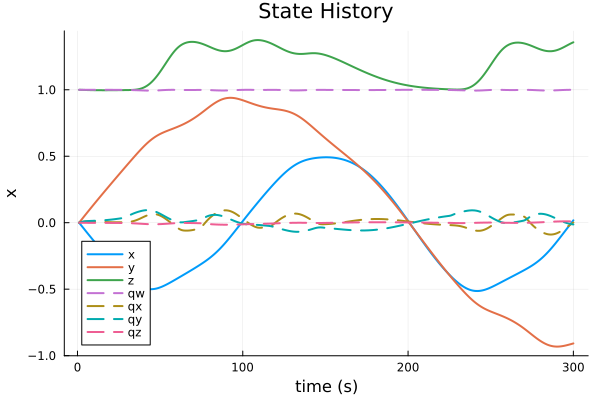

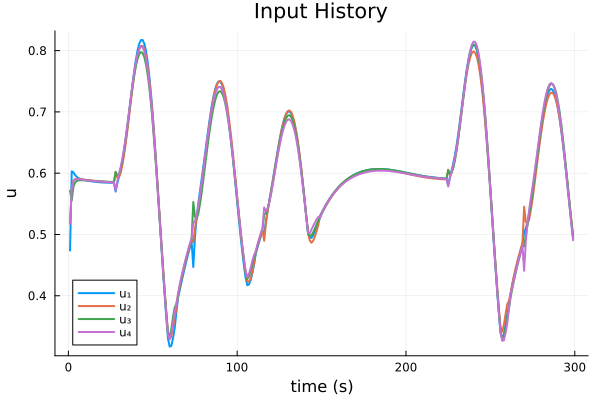

35.00832990911356

In [169]:
Xsim_m = mat_from_vec(xhist[1:Nsim] - 0 * Xref[1:Nsim])
Usim_m = mat_from_vec(uhist[1:Nsim-1])
display(plot(Xsim_m[1:7, :]', label=["x" "y" "z" "qw" "qx" "qy" "qz"],
  linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
  title="State History", xlabel="time (s)", ylabel="x"))
display(plot(Usim_m', label=["u₁" "u₂" "u₃" "u₄"],
  title="Input History", linewidth=[2 2 2 2 2 2 2],
  xlabel="time (s)", ylabel="u"))
norm(xhist[1:Nsim] - 0 * Xref[1:Nsim])

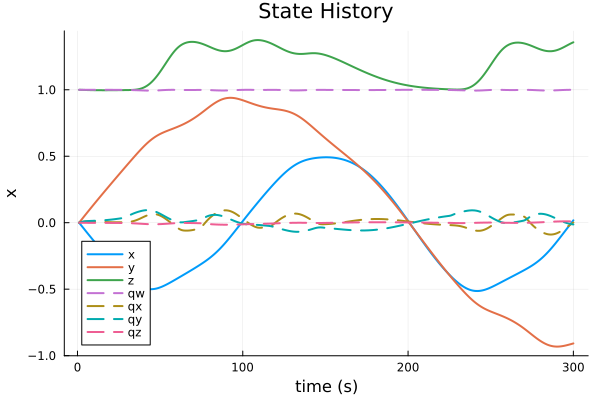

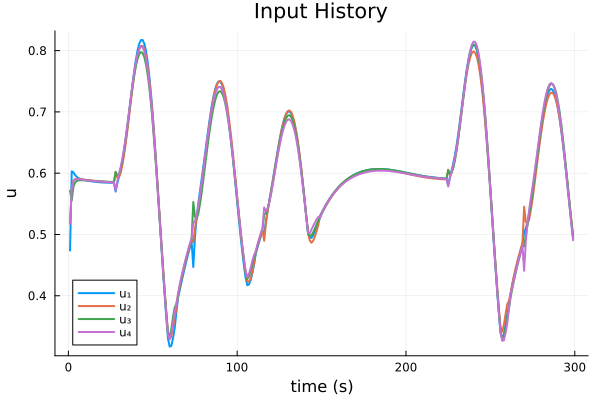

35.00832990911356

In [170]:
Xsim_m = mat_from_vec(xhist[1:Nsim])
Usim_m = mat_from_vec(uhist[1:Nsim-1])
display(plot(Xsim_m[1:7, :]', label=["x" "y" "z" "qw" "qx" "qy" "qz"],
  linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
  title="State History", xlabel="time (s)", ylabel="x"))
display(plot(Usim_m', label=["u₁" "u₂" "u₃" "u₄"],
  title="Input History", linewidth=[2 2 2 2 2 2 2],
  xlabel="time (s)", ylabel="u"))
norm(xhist[1:Nsim] - 0 * Xref[1:Nsim])

In [171]:
# function export_mat_to_eigen(prefix, data)
#   str = prefix * "\n"
#   for i = 1:size(data, 1)
#       for j = 1:size(data, 2)
#           this_str = @sprintf("%.6f", data[i, j])
#           str = str * this_str * "f"
#           if (i == size(data, 1) && j == size(data, 2))
#             str = str * ").finished();"
#           else
#             str = str * ","
#           end
#       end
#       str = str * "\n"
#   end
#   str = str * "\n"
#   return str
# end

function export_mat_to_eigen(prefix, data)
  str = prefix * "\n"
  for i = 1:size(data, 1)
      for j = 1:size(data, 2)
          this_str = @sprintf("%.6f", data[i, j])
          str = str * this_str * "f"
          if (i == size(data, 1) && j == size(data, 2))
            str = str * ";"
          else
            str = str * ","
          end
      end
      str = str * "\n"
  end
  str = str * "\n"
  return str
end

@printf("%s",export_mat_to_eigen("A << ", Ã))
@printf("%s",export_mat_to_eigen("B << ", B̃))
@printf("%s",export_mat_to_eigen("Kinf << ", cache.Kinf))
@printf("%s",export_mat_to_eigen("Pinf << ", cache.Pinf))
@printf("%s",export_mat_to_eigen("Quu_inv << ", cache.Quu_inv))
@printf("%s",export_mat_to_eigen("AmBKt << ",   cache.AmBKt))
@printf("%s",export_mat_to_eigen("coeff_d2p << ", cache.coeff_d2p))
@printf("%s",export_mat_to_eigen("Q << ", Q))
@printf("%s",export_mat_to_eigen("R << ", R))
# @printf("%s",export_mat_to_eigen("Kinf_data[NINPUTS*NSTATES]", cache.Kinf2))
# @printf("%s",export_mat_to_eigen("Pinf_data[NSTATES*NSTATES]", cache.Pinf2))
# @printf("%s",export_mat_to_eigen("Quu_inv_data[NINPUTS*NINPUTS]", cache.Quu_inv2))
# @printf("%s",export_mat_to_eigen("AmBKt_data[NSTATES*NSTATES]", cache.AmBKt2))
# @printf("%s",export_mat_to_eigen("coeff_d2p_data[NSTATES*NINPUTS]", cache.coeff_d2p2))

A << 
1.000000f,0.000000f,0.000000f,0.000000f,0.003924f,0.000000f,0.020000f,0.000000f,0.000000f,0.000000f,0.000013f,0.000000f,
0.000000f,1.000000f,0.000000f,-0.003924f,0.000000f,0.000000f,0.000000f,0.020000f,0.000000f,-0.000013f,0.000000f,0.000000f,
0.000000f,0.000000f,1.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.020000f,0.000000f,0.000000f,0.000000f,
0.000000f,0.000000f,0.000000f,1.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.010000f,0.000000f,0.000000f,
0.000000f,0.000000f,0.000000f,0.000000f,1.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.010000f,0.000000f,
0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,1.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.010000f,
0.000000f,0.000000f,0.000000f,0.000000f,0.392400f,0.000000f,1.000000f,0.000000f,0.000000f,0.000000f,0.001962f,0.000000f,
0.000000f,0.000000f,0.000000f,-0.392400f,0.000000f,0.000000f,0.000000f,1.000000f,0.000000f,-0.001962f,0.000000f,0.000000f,
0.000000f,0.000000f,0.

In [172]:
# X_ref_data = [Δx̃ref[i][1:12] for i = 1:Nt]
# # Export a vector of Eigen matrix to C header and source 
# function export_vec_to_c(filename, var_type, var_name, data)
#   declare = "static Eigen::" * var_type * " " * var_name
#   def = declare * " = {\n"
#   for i=1:length(data)
#       def = def * "(Eigen::" * var_type * "() << "
#       for j=1:length(data[1])
#           def = def * string(data[i][j])
#           if j < length(data[1]) 
#               def = def * ","
#           end
#       end
#     def = def * ").finished(),\n"
#   end
#   def = def*"}"

#   open(filename*".h","a") do io
#           println(io, def * ";\n")
#   end
#   return true
# end
# export_vec_to_c("data", "VectorNf", "XrefAll[]", X_ref_data)